# Analysis of Yelp Data

## Data source

Three datasets (user, review, and business) were used for this analysis. All datasets are can be found on [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset). The datasets were uploaded to AWS S3 bucket s3://yelpdata-ak/yelp/yelp_academic_dataset_business.json

## Objectives

The objective is to use Apache Spark on AWS EMR while accessing data sets from AWS S3 to analyze a few million data points. 

(1) **Business** dataset is used to find the most abundant business types (categories).

(2) **Review** and **Business** datasets are both used to see if reviews, who leave textual reviews, rate businesses more or less highly as compared to the overall business rating. 

(3) **User** and **Business** datasets are used to see if *elite* reviewers rate businesses any differently than regular reviewers. 

In [1]:
%info

List of available packages:

In [2]:
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1588528583017_0004,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
jmespath                   0.9.4
lxml                       4.4.2
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.14.5
pip                        20.1
py-dateutil                2.2
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
setuptools                 46.1.3
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.34.2
windmill                   1.6

Installing Pandas and Matplotlib:

In [3]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

## Part I
**Business** datasets is loaded from AWS S3. Data schema is printed below as well as the total numbers of 
columns and rows.

In [36]:

df_business = spark.read.json('s3://yelpdataset-ak/yelp/yelp_academic_dataset_business.json')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
print(f'Total Columns: {len(df_business.dtypes)}')
print(f'Total Rows: {df_business.count():,}')
df_business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable

Spark SQL is used to select *business_id*, *name*, *city*, *state*, and *stars* columns from the Spark.SQL table (Business) for data viewing purposes.

In [6]:
df_business.createOrReplaceTempView('Business')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
sql_business = spark.sql(
'''
SELECT `business_id`, `name`, `city`, `state`, `stars`, `categories` FROM Business
LIMIT 5
'''
)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
sql_business.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+-----+--------------------+
|         business_id|                name|           city|state|stars|          categories|
+--------------------+--------------------+---------------+-----+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|  3.5|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|  5.0|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|  5.0|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|  2.5|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|  4.5|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+-----+--------------------+

Spark.DataFrame (df_business) is denormalized so as to unroll a column with multiple categories into a column with single category per row that is still linked to its appropriate business_id. This denormalized table format allows for 
computing total number of businesses per category (business type). 

In [9]:
import pyspark.sql.functions as f
denormalized_business=df_business.select("business_id", 
                   f.posexplode(f.split("categories", ", ")).alias("pos", "category")).drop("pos")
denormalized_business.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

There are 1336 unique business types.

In [10]:
denormalized_business.select("category").distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

Counting of businesses within each unique business category.

In [11]:
category_count = denormalized_business.groupBy(denormalized_business.category).count()
category_count.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|           category|count|
+-------------------+-----+
|     Paddleboarding|   36|
|     Dermatologists|  341|
|   Historical Tours|   54|
|   Hot Air Balloons|   21|
|Mobile Home Dealers|   16|
+-------------------+-----+
only showing top 5 rows

Arranging categories in descending order by business count in each category. 

In [12]:

category_count_desc = category_count.sort("count", ascending=False)
category_count_desc.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-----+
|     category|count|
+-------------+-----+
|  Restaurants|63944|
|     Shopping|34644|
|         Food|32991|
|Home Services|22487|
|Beauty & Spas|20520|
+-------------+-----+
only showing top 5 rows

Below is the graph for 20 most prevalent busienss categories on Yelp. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

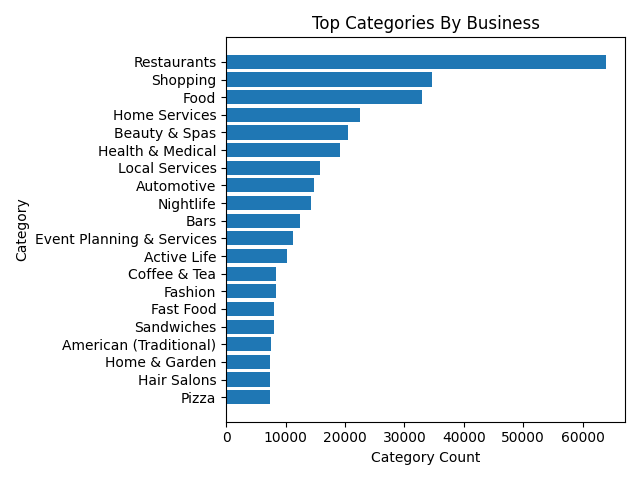

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
category_count_desc_Pandas = category_count_desc.toPandas()
plt.clf()
plt.barh(category_count_desc_Pandas["category"][0:20],category_count_desc_Pandas["count"][0:20])
plt.title("Top Categories By Business")
plt.xlabel("Category Count", fontsize=10)
plt.ylabel("Category", fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()
%matplot plt



# Part II

**Review** and **Business** datasets are both used to see if reviews, who leave textual reviews, rate businesses more or less highly as compared to the overall business rating.

**Business** datasets is loaded from AWS S3 as Spark.DataFrame dataset. Data schema is printed below as well as the total numbers of columns and rows.

In [14]:
df_review = spark.read.json('s3://yelpdataset-ak/yelp/yelp_academic_dataset_review.json')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
print(f'Total Columns: {len(df_review.dtypes)}')
print(f'Total Rows: {df_review.count():,}')
df_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 9
Total Rows: 8,021,122
root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

The df_review is limited to two columns. 

In [16]:
df_review_two_cols = df_review.select("business_id", "stars")
df_review_two_cols.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

The *stars* column is grouped and averaged by *business_id*.

In [17]:
df_avg_stars = df_review_two_cols.groupBy("business_id").mean("stars").withColumnRenamed("avg(stars)","avg_stars")
df_avg_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|         avg_stars|
+--------------------+------------------+
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vQGZjrDiDBuznOkUe...| 4.454545454545454|
|vyu1WGlnHGv2Z2MVE...|               5.0|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

The dataframe **df_business** from PartI and newly created **df_avg_stars** are joined together on *business_id* column. 

In [18]:
df_joined = df_avg_stars.join(df_business, df_avg_stars.business_id==df_business.business_id, "inner")\
.select("stars", "avg_stars", "name", "city", "state").sort("avg_stars", ascending=False)
df_joined.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+---------+--------------------+----------+-----+
|stars|avg_stars|                name|      city|state|
+-----+---------+--------------------+----------+-----+
|  5.0|      5.0|          Mane.edits| Charlotte|   NC|
|  5.0|      5.0|      Thomas S Holly|   Phoenix|   AZ|
|  5.0|      5.0|       The Amburgeys|   Gilbert|   AZ|
|  5.0|      5.0|Jane Bloch - Cold...|Pittsburgh|   PA|
|  5.0|      5.0| Arizona Microgreens|   Phoenix|   AZ|
+-----+---------+--------------------+----------+-----+
only showing top 5 rows

The joined table can now be used to calculate the difference between average star rating of people who left texual review and overall business rating for each business in this joined dataset. 

In [19]:
df_joined.createOrReplaceTempView('Joined')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
sql_diff = spark.sql(
'''

SELECT (`avg_stars`-`stars`)/`stars` AS diff FROM Joined 

'''
)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Differences in two types of ratings are plotted as a distribution. From the graphic it appears that both types of reviewers review businesses in similar manner.

In [21]:
diff_pandas = sql_diff.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

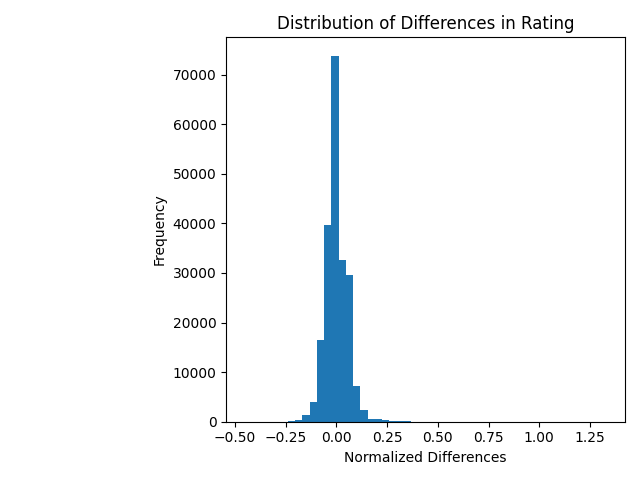

In [22]:
plt.clf()
plt.hist(diff_pandas["diff"], 50)
plt.title("Distribution of Differences in Rating")
plt.xlabel("Normalized Differences", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.show()
%matplot plt

# Part III

**User** and **Business** datasets are used to see if *elite* reviewers rate businesses any differently than regular reviewers.


In [23]:
df_user = spark.read.json('s3://yelpdataset-ak/yelp/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Visualization of the **User** dataset.

In [24]:
df_user.createOrReplaceTempView('User')
sql_user = spark.sql(
'''
SELECT `elite`, `name`, `average_stars` FROM User

'''
)
sql_user.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+-------------+
|               elite|    name|average_stars|
+--------------------+--------+-------------+
|                    |  Rafael|         3.57|
|2008,2009,2010,20...|Michelle|         3.84|
|                2010|  Martin|         3.44|
|                2009|    John|         3.08|
|2009,2010,2011,20...|    Anne|         4.37|
+--------------------+--------+-------------+
only showing top 5 rows

In [25]:
print(f'Total Rows: {df_business.count():,}')
print(f'Total Rows: {df_user.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Rows: 209,393
Total Rows: 1,968,703

**User** dataset is altered so as to eliminate empty rows within the *elite* column. 

In [35]:
user_elite = spark.sql(
'''
SELECT `elite`, `name`, `average_stars` FROM User
where `elite` != ''

'''
)
user_elite.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

75961

Spark.DataFrames for **Business** and altered **User** datasets are convered to pandas dataframes for plotting data
with matplotlib. 

In [27]:
business_pandas = df_business.toPandas()
user_elite_pandas = user_elite.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Below are the boxplots for each of the datasets, regular vs elite Yelp user. The boxplots show that elite user ratings
have a narrower distribution around the median and there are significant number of outliers since the interquartile 
range is much narrower for elite user ratings than it is for the regular user ratings. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

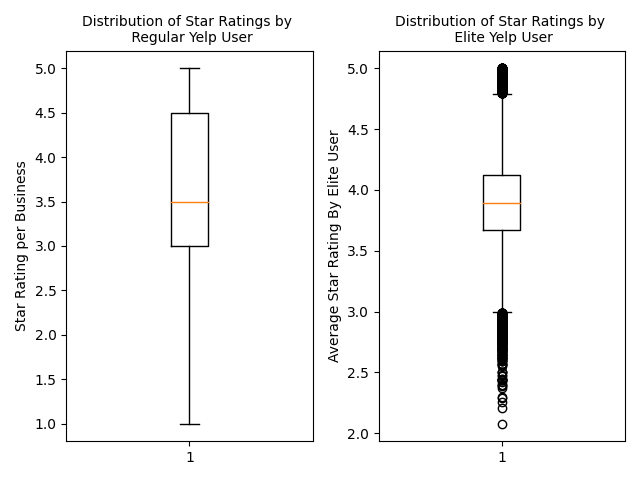

In [28]:
plt.clf()

plt.subplot(1,2,1)
plt.boxplot(business_pandas["stars"])
plt.title("Distribution of Star Ratings by \n Regular Yelp User", fontsize=10)
plt.ylabel("Star Rating per Business", fontsize=10)
plt.tight_layout()

plt.subplot(1,2,2)
plt.boxplot(user_elite_pandas["average_stars"])
plt.title("Distribution of Star Ratings by \n Elite Yelp User", fontsize=10)
plt.ylabel("Average Star Rating By Elite User", fontsize=10)
plt.tight_layout()
plt.show()
%matplot plt

Below are the summary statistics for elite and regular user ratings. The standard deviation of elite user ratings is significantly smaller (0.336) in comparison to the standard deviation for regular user ratings (1.023). 

In [29]:
user_elite.select("average_stars").summary().withColumnRenamed("average_stars", "average stars elite user").show()
df_business.select("stars").summary().withColumnRenamed("stars", "stars regular user").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------------+
|summary|average stars elite user|
+-------+------------------------+
|  count|                   75961|
|   mean|       3.893900027645765|
| stddev|      0.3362066429311774|
|    min|                    2.08|
|    25%|                    3.67|
|    50%|                    3.89|
|    75%|                    4.12|
|    max|                     5.0|
+-------+------------------------+

+-------+------------------+
|summary|stars regular user|
+-------+------------------+
|  count|            209393|
|   mean|3.5380552358483808|
| stddev|1.0235430346225864|
|    min|               1.0|
|    25%|               3.0|
|    50%|               3.5|
|    75%|               4.5|
|    max|               5.0|
+-------+------------------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

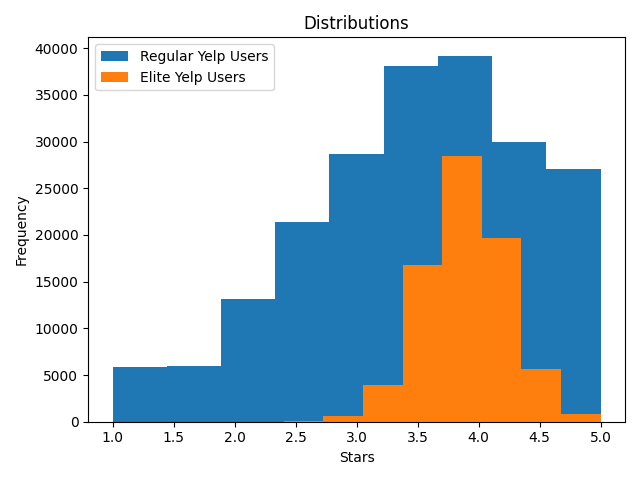

In [33]:
plt.clf()
plt.hist(business_pandas["stars"], 9, label= "Regular Yelp Users")
plt.xlabel("Stars", fontsize=10)
plt.ylabel("Frequency", fontsize=10)


plt.hist(user_elite_pandas["average_stars"], 9, label= "Elite Yelp Users")
plt.xlabel("Stars", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.tight_layout()
plt.legend(loc="best")
plt.title("Distributions")
plt.tight_layout()
plt.show()
%matplot plt